This notebook continues the pipeline by preparing the cleaned training and test datasets for modeling. Question pairs are combined and rigorously preprocessed through normalization, tokenization, and stemming, ensuring consistent text input for feature engineering. A coverage analysis of frequent words guides the optimal choice of feature size, while both TF-IDF and Bag-of-Words representations are created to capture the most meaningful textual patterns.

In addition, the notebook introduces the extraction of BERT-based word embeddings, leveraging pretrained deep language models to capture rich semantic relationships between questions. These modern embeddings complement traditional vectorization methods, providing advanced features that can significantly improve the performance of machine learning models for duplicate question detection.

Together, these steps establish a robust and well-structured foundation for effective model training and evaluation.

# Imports

In [3]:
import sys
sys.path.append('..') 

import pandas as pd
import joblib
import gc # garbage collector
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from src.preprocessing.text_cleaner import TextCleaner
from src.analysis.word_coverage import TopWordsCoverage
from src.features.vectorizer import Vectorizer
from src.features.bert_embedder import BertEmbedder
from src.features.similarity import TextEmbedder, TextSimilarity, compute_and_save_bert_features

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\allen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_train = pd.read_csv("../data/processed/quora_train_cleaned.csv")
df_test = pd.read_csv("../data/raw/quora_question_pairs_test.csv.zip")
df_test = df_test.dropna()

# Combine question pairs for feature extraction
df_test["combined_text"] = df_test["question1"].astype(str) + " " + df_test["question2"].astype(str)

print(df_train.shape, df_test.shape)


(322899, 7) (80858, 7)


# Text Preprocessing

In [5]:
cleaner = TextCleaner(language="english")
df_train["cleaned_text"] = df_train["combined_text"].map(cleaner)
df_test["cleaned_text"] = df_test["combined_text"].map(cleaner)

In [6]:
print(df_train.loc[5, "cleaned_text"])

got seat engin manag ketter univers good go build career opportun cours petroleum engin got offer scotland univers energi econom cours go job opportun


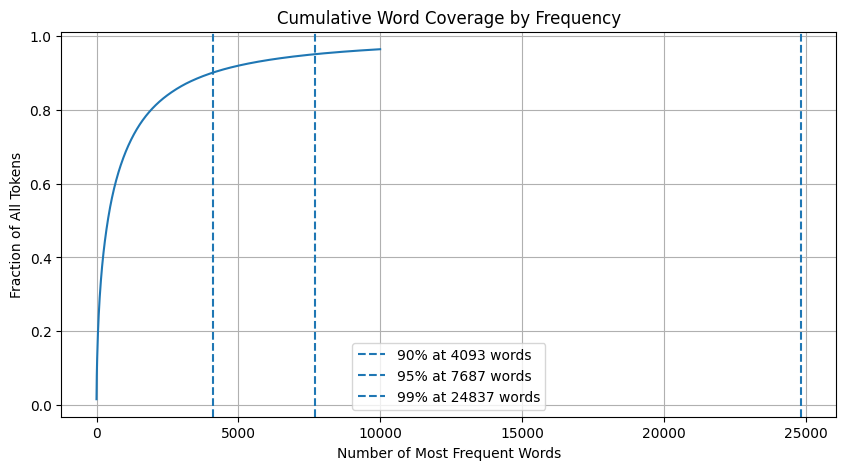

90% of the corpus is covered by 4093 words.
95% of the corpus is covered by 7687 words.
99% of the corpus is covered by 24837 words.


In [7]:
# Top-N words coverage analysis
TopWordsCoverage.plot_coverage(df_train["cleaned_text"])

# Feature Extraction

## Vectorizers TF-IDF and Bag-of-Words

In [8]:
TOP_N_WORDS = 8000

# Initialize for TF-IDF
tfidf_vec = Vectorizer(max_features=TOP_N_WORDS, mode="tfidf")
X_train_tfidf = tfidf_vec.fit_transform(df_train["cleaned_text"])
X_test_tfidf = tfidf_vec.transform(df_test["cleaned_text"])

print(f"TF-IDF feature matrix shape (train): {X_train_tfidf.shape}")
print(f"Sample TF-IDF words: {tfidf_vec.get_feature_names()[:10]}")

# For Bag-of-Words
bow_vec = Vectorizer(max_features=TOP_N_WORDS, mode="bow")
X_train_bow = bow_vec.fit_transform(df_train["cleaned_text"])
X_test_bow = bow_vec.transform(df_test["cleaned_text"])

print(f"Bag-of-Words feature matrix shape (train): {X_train_bow.shape}")
print(f"Sample BoW words: {bow_vec.get_feature_names()[:10]}")

TF-IDF feature matrix shape (train): (322899, 8000)
Sample TF-IDF words: ['aa' 'aadhaar' 'aadhar' 'aadmi' 'aakash' 'aam' 'aamir' 'aao' 'aap' 'ab']
Bag-of-Words feature matrix shape (train): (322899, 8000)
Sample BoW words: ['aa' 'aadhaar' 'aadhar' 'aadmi' 'aakash' 'aam' 'aamir' 'aao' 'aap' 'ab']


## BERT embedder

In [9]:
embedder = BertEmbedder()

sample_q1 = df_train["question1"].iloc[0]
sample_q2 = df_train["question2"].iloc[0]

print("=== Embedding info for question1 ===")
embedder.show_embedding_info(sample_q1)

print("\n=== Embedding info for question2 ===")
embedder.show_embedding_info(sample_q2)

=== Embedding info for question1 ===
Number of tokens: 13
Tokens and embedding shapes (first 5):
       [CLS] | torch.Size([768]) | tensor([-0.3343, -0.0158, -0.3860, -0.1671, -0.4662])...
         the | torch.Size([768]) | tensor([-0.1967,  0.1060, -0.9988, -0.5399,  0.0820])...
          il | torch.Size([768]) | tensor([ 0.2538, -0.4263, -0.9351, -0.5399,  1.0454])...
       ##iad | torch.Size([768]) | tensor([-0.3202, -0.0320, -0.9122, -0.7090,  0.8641])...
         and | torch.Size([768]) | tensor([-0.6941,  0.2808, -0.6976,  0.0467, -0.3230])...
CLS embedding (first 10 values): [-0.33433712 -0.01576164 -0.3860178  -0.16710731 -0.46615177  0.13293208
  0.41615364  0.8386875  -0.27585348 -0.29118982]

=== Embedding info for question2 ===
Number of tokens: 17
Tokens and embedding shapes (first 5):
       [CLS] | torch.Size([768]) | tensor([-0.2196,  0.0510, -0.2668, -0.0574, -0.4785])...
         how | torch.Size([768]) | tensor([-0.0018,  0.2372, -0.5509, -0.1360,  0.5474])...
     

If two questions have similar [CLS] embeddings, they are likely to be semantically similar, even if their wordings are different.

In [10]:
# Saving the processed data and vectorizer
df_train.to_csv("../data/processed/cleaned_train.csv", index=False)

joblib.dump(tfidf_vec, "../src/models/tfidf_vectorizer.joblib")

['../src/models/tfidf_vectorizer.joblib']

# Text Similarity

## Cosine Similarity

In [11]:
embedder = TextEmbedder(model_name="bert-base-uncased")
compute_and_save_bert_features(df_train, embedder, "../data/processed/quora_train", batch_size=64)
compute_and_save_bert_features(df_test, embedder, "../data/processed/quora_test", batch_size=64)

Number of unique questions: 448517


BERT embeddings: 100%|██████████| 7009/7009 [41:41<00:00,  2.80it/s]


Saved to ../data/processed/quora_train_embeddings.npy, shape: (448517, 768)
Saved ../data/processed/quora_train_with_bert_sim.csv and .npy embeddings.
Number of unique questions: 137701


BERT embeddings: 100%|██████████| 2152/2152 [12:17<00:00,  2.92it/s]


Saved to ../data/processed/quora_test_embeddings.npy, shape: (137701, 768)
Saved ../data/processed/quora_test_with_bert_sim.csv and .npy embeddings.
